In [1]:
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from keras.utils.vis_utils import model_to_dot
import os
import matplotlib.pyplot as plot
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as CM
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import pandas as pd                               
from keras import models
from keras import layers            
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
label_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
get_label = {label_names:i for i, label_names in enumerate(label_names)}
IMAGE_Shape = (150, 150)

In [3]:
print(label_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [4]:
def mylistdir(directory):
    """A specialized version of os.listdir() that ignores files that
    start with a leading period."""
    filelist = os.listdir(directory)
    return [x for x in filelist
            if not (x.startswith('.'))]

# Loading Images and Labels

In [5]:
def load_data():
    
    datasets = ['seg_train/seg_train', 
                "seg_test/seg_test"]
    output = []

    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        for folder in mylistdir(dataset):
            label = get_label[folder]
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                img_path = os.path.join(os.path.join(dataset, folder), file)

                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_Shape) 
      
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [6]:
(train_images, train_labels), (validation_images, validation_labels) = load_data()

  2%|▏         | 37/2271 [00:00<00:06, 357.38it/s]

Loading seg_train/seg_train


  6%|▌         | 28/474 [00:00<00:01, 278.74it/s]

Loading seg_test/seg_test


100%|██████████| 510/510 [00:01<00:00, 498.31it/s]


In [7]:
print("The shape of training images is",train_images.shape )
print("The shape of training labels is",train_labels.shape )
print("The shape of testing images is",validation_images.shape )
print("The shape of testing images is",validation_labels.shape )

The shape of training images is (14034, 150, 150, 3)
The shape of training labels is (14034,)
The shape of testing images is (3000, 150, 150, 3)
The shape of testing images is (3000,)


# Scaling Images

In [8]:
train_images = train_images / 255.0 
validation_images = validation_images / 255.0

# Display Images

In [9]:
def show_plot(images,labels):
    index = np.random.randint(images.shape[0])
    plot.figure()
    plot.imshow(images[index])
    plot.xticks([])
    plot.yticks([])
    plot.grid(False)
    plot.title(label_names[labels[index]])
    plot.show()

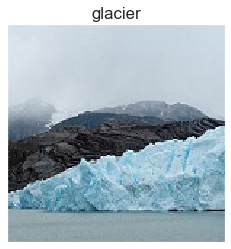

In [10]:
show_plot(train_images,train_labels)

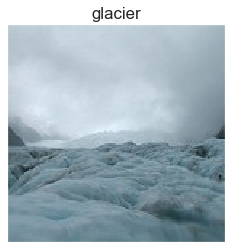

In [11]:
show_plot(validation_images,validation_labels)

# The Numbers of  Labels in Each Classes#



In [12]:

train_data_count = np.zeros(6)
val_data_count = np.zeros(6)
for i in range(6):
    train_data_count[i] = np.count_nonzero( train_labels== i)
for i in range(6):
    val_data_count[i] = np.count_nonzero( validation_labels== i)
train_data_count

array([2191., 2271., 2404., 2512., 2274., 2382.])

In [13]:
print("In train images, buildings has",train_data_count[0])
print("In train images,forest has",train_data_count[1])
print("In train images, glacier has",train_data_count[2])
print("In train images, mountain has",train_data_count[3])
print("In train images,sea has",train_data_count[4])
print("In train images,street has",train_data_count[5])

print("In validation images, buildings has",val_data_count[0])
print("In validation images,forest has",val_data_count[1])
print("In validation images, glacier has",val_data_count[2])
print("In validation images, mountain has",val_data_count[3])
print("In validation images,sea has",val_data_count[4])
print("In validation images,street has",val_data_count[5])

In train images, buildings has 2191.0
In train images,forest has 2271.0
In train images, glacier has 2404.0
In train images, mountain has 2512.0
In train images,sea has 2274.0
In train images,street has 2382.0
In validation images, buildings has 437.0
In validation images,forest has 474.0
In validation images, glacier has 553.0
In validation images, mountain has 525.0
In validation images,sea has 510.0
In validation images,street has 501.0


In [14]:
def subset_mnist_training(images,label,per_image):
    
    subset_image = np.ones((1,images.shape[1],images.shape[2],images.shape[3]))
    subset_label = np.array([])
    
    for i in range(6):
        subset_index = np.where(label == i)
        subset_index = np.asarray(subset_index)
        subset_index = subset_index.T
        subset_index = subset_index[:per_image,]
        subset_L = np.take(label, subset_index)
        subset_L = subset_L.reshape(per_image,)
        subset_label = np.concatenate((subset_label, subset_L), axis=None)
        subset_I = np.take(images, subset_index, axis=0)
        subset_I = subset_I.reshape(per_image,images.shape[1],
                                    images.shape[2],images.shape[3])
        
        subset_image = np.concatenate((subset_image, subset_I))
        
        
        
    subset_image=np.delete(subset_image, (0), axis=0)   
    
    return   subset_image, subset_label

## Getting subset train images

Since the shape of our training images is 14034, 150, 150, 3.  Then, this study wants to have a subset of training images and training labels.  So, it takes the first 1000 of each class.

In [15]:
sub_train_img,sub_train_labels = subset_mnist_training(train_images, train_labels,500)
sub_val_img,sub_val_labels = subset_mnist_training(validation_images, validation_labels,200)

In [16]:
print("The shape of subset training images is", sub_train_img.shape)
print("The shape of subset training labels is", sub_train_labels.shape)

The shape of subset training images is (3000, 150, 150, 3)
The shape of subset training labels is (3000,)


In [17]:
sub_train_labels = sub_train_labels.astype(np.int32)
sub_val_labels = sub_val_labels.astype(np.int32)

In [18]:
train_y = to_categorical(sub_train_labels)

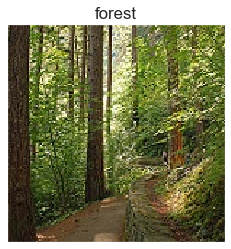

In [19]:
show_plot(sub_train_img,sub_train_labels)

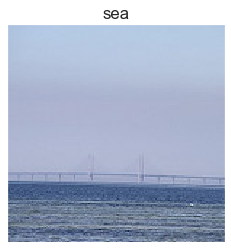

In [20]:
show_plot(sub_val_img,sub_val_labels)

## 1. Basic CNN

### 1.1 Define Basic CNN Model

In [21]:
from keras import layers
from keras import models
from keras import regularizers

model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn.add(layers.Dense(6, activation='softmax'))

In [22]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               5308544   
_________________________________________________________________
dense_2 (Dense)              (None, 6)                

In [23]:
from keras import optimizers
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [24]:
history = model_cnn.fit(sub_train_img, sub_train_labels, batch_size=128, epochs=20, 
              validation_data=(sub_val_img,sub_val_labels))




Train on 3000 samples, validate on 1200 samples
Epoch 1/20
3000/3000 [==============================] - 55s 18ms/step - loss: 1.9791 - accuracy: 0.3093 - val_loss: 1.5742 - val_accuracy: 0.4233
Epoch 2/20
3000/3000 [==============================] - 54s 18ms/step - loss: 1.3388 - accuracy: 0.5587 - val_loss: 1.1886 - val_accuracy: 0.6317
Epoch 3/20
3000/3000 [==============================] - 53s 18ms/step - loss: 1.0345 - accuracy: 0.6853 - val_loss: 1.0926 - val_accuracy: 0.6342
Epoch 4/20
3000/3000 [==============================] - 58s 19ms/step - loss: 0.9018 - accuracy: 0.7440 - val_loss: 1.0952 - val_accuracy: 0.6733
Epoch 5/20
3000/3000 [==============================] - 63s 21ms/step - loss: 0.8297 - accuracy: 0.7650 - val_loss: 1.0212 - val_accuracy: 0.6875
Epoch 6/20
3000/3000 [==============================] - 58s 19ms/step - loss: 0.7303 - accuracy: 0.8093 - val_loss: 0.9525 - val_accuracy: 0.7108
Epoch 7/20
3000/3000 [==============================] - 56s 19ms/step - loss

### 1.2 Basic CNN Accuracy and Loss

In [26]:
val_loss_cnn = model_cnn.evaluate(sub_val_img,sub_val_labels)
print(val_loss_cnn)

1200/1200 [==============================] - 4s 3ms/step
[1.2478174710273742, 0.6850000023841858]


In [27]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

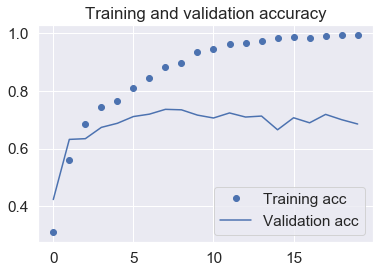

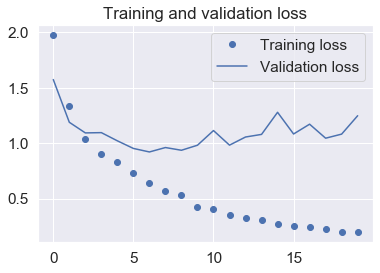

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plot.plot(epochs, acc, 'bo', label='Training acc')
plot.plot(epochs, val_acc, 'b', label='Validation acc')
plot.title('Training and validation accuracy')
plot.legend()

plot.figure()

plot.plot(epochs, loss, 'bo', label='Training loss')
plot.plot(epochs, val_loss, 'b', label='Validation loss')
plot.title('Training and validation loss')
plot.legend()

plot.show()

## 2. Using the Convolutional Base of the VGG16 Network

In [29]:
from keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

In [30]:

vgg16_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [31]:
vgg16_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### 2.1 Extract Feature

In [32]:
train_features = vgg16_base.predict(sub_train_img)
val_features = vgg16_base.predict(sub_val_img)

In [33]:
print(val_features.shape)

(1200, 4, 4, 512)


### 2.2 Stack Top layers

In [34]:
from keras import models
from keras import layers
from keras import optimizers
model_VGG = models.Sequential()
model_VGG.add(layers.Conv2D(64, (3, 3), activation='relu',input_shape=(4, 4, 512)))
model_VGG.add(layers.Dropout(0.5))
model_VGG.add(layers.Flatten())
model_VGG.add(layers.Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model_VGG.add(layers.Dense(6, activation='softmax'))
model_VGG.compile(optimizer=Optimizer.Adam(lr=0.0001),
                       loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [35]:
model_VGG.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 2, 2, 64)          294976    
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 6150      
Total params: 564,294
Trainable params: 564,294
Non-trainable params: 0
_________________________________________________________________


In [36]:
history_VGG =  model_VGG.fit(train_features, sub_train_labels, batch_size=128, epochs=30, 
                    validation_data=(val_features, sub_val_labels))


Train on 3000 samples, validate on 1200 samples
Epoch 1/30
3000/3000 [==============================] - 0s 157us/step - loss: 2.0969 - accuracy: 0.3190 - val_loss: 1.8132 - val_accuracy: 0.6900
Epoch 2/30
3000/3000 [==============================] - 0s 73us/step - loss: 1.5873 - accuracy: 0.6007 - val_loss: 1.2283 - val_accuracy: 0.7400
Epoch 3/30
3000/3000 [==============================] - 0s 72us/step - loss: 1.1978 - accuracy: 0.6933 - val_loss: 0.9960 - val_accuracy: 0.7825
Epoch 4/30
3000/3000 [==============================] - 0s 71us/step - loss: 1.0185 - accuracy: 0.7523 - val_loss: 0.9015 - val_accuracy: 0.7950
Epoch 5/30
3000/3000 [==============================] - 0s 72us/step - loss: 0.9254 - accuracy: 0.7853 - val_loss: 0.8480 - val_accuracy: 0.8158
Epoch 6/30
3000/3000 [==============================] - 0s 72us/step - loss: 0.8745 - accuracy: 0.8143 - val_loss: 0.8064 - val_accuracy: 0.8367
Epoch 7/30
3000/3000 [==============================] - 0s 71us/step - loss: 0.81

### 2.3  Accuracy and Loss

In [37]:
val_loss_VGG = model_VGG.evaluate(val_features, sub_val_labels)
print(val_loss_VGG)

1200/1200 [==============================] - 0s 52us/step
[0.647650195757548, 0.8708333373069763]


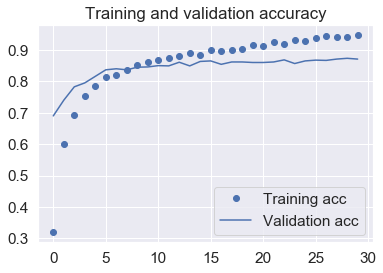

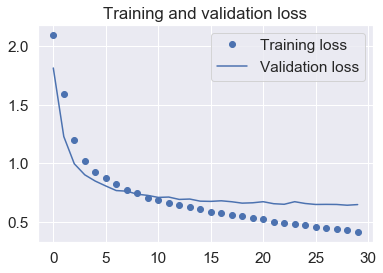

In [38]:
acc = history_VGG.history['accuracy']
val_acc = history_VGG.history['val_accuracy']
loss = history_VGG.history['loss']
val_loss = history_VGG.history['val_loss']

epochs = range(len(acc))

plot.plot(epochs, acc, 'bo', label='Training acc')
plot.plot(epochs, val_acc, 'b', label='Validation acc')
plot.title('Training and validation accuracy')
plot.legend()

plot.figure()

plot.plot(epochs, loss, 'bo', label='Training loss')
plot.plot(epochs, val_loss, 'b', label='Validation loss')
plot.title('Training and validation loss')
plot.legend()

plot.show()

## 3. Using the Convolutional Base of the InceptionV3 Network 

In [39]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input

# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(150, 150, 3))

InceptionV3_base = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

### 3.1 Extract Feature

In [40]:
train_featuresV3 = InceptionV3_base.predict(sub_train_img)
val_featuresV3 = InceptionV3_base.predict(sub_val_img)

In [41]:
print(sub_val_img.shape)
print(train_featuresV3.shape)

(1200, 150, 150, 3)
(3000, 3, 3, 2048)


### 3.2 Apply onee hot encode

In [42]:
from keras.utils import to_categorical
y_train = to_categorical(sub_train_labels)
y_val = to_categorical(sub_val_labels)

### 3.3 Stack Top layers

In [43]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
model_InceeptionV3 = models.Sequential()
model_InceeptionV3.add(layers.GlobalAveragePooling2D(input_shape=(3, 3, 2048)))
model_InceeptionV3.add(layers.Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model_InceeptionV3.add(layers.Dense(6, activation='softmax'))
model_InceeptionV3.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [44]:
history_V3 = model_InceeptionV3.fit(train_featuresV3, y_train, batch_size=128, epochs=20, 
                    validation_data=(val_featuresV3, y_val))


Train on 3000 samples, validate on 1200 samples
Epoch 1/20
3000/3000 [==============================] - 1s 217us/step - loss: 5.7384 - accuracy: 0.5757 - val_loss: 1.9028 - val_accuracy: 0.7925
Epoch 2/20
3000/3000 [==============================] - 0s 144us/step - loss: 1.9809 - accuracy: 0.7970 - val_loss: 1.5298 - val_accuracy: 0.8683
Epoch 3/20
3000/3000 [==============================] - 0s 143us/step - loss: 1.5833 - accuracy: 0.8287 - val_loss: 1.6887 - val_accuracy: 0.7642
Epoch 4/20
3000/3000 [==============================] - 0s 145us/step - loss: 1.4510 - accuracy: 0.8140 - val_loss: 1.0388 - val_accuracy: 0.8817
Epoch 5/20
3000/3000 [==============================] - 0s 143us/step - loss: 1.1784 - accuracy: 0.8387 - val_loss: 1.1540 - val_accuracy: 0.8333
Epoch 6/20
3000/3000 [==============================] - 0s 143us/step - loss: 1.1377 - accuracy: 0.8233 - val_loss: 1.6367 - val_accuracy: 0.7317
Epoch 7/20
3000/3000 [==============================] - 0s 145us/step - loss

### 3.3  Accuracy and Loss

In [45]:
val_loss_V3 = model_InceeptionV3.evaluate(val_featuresV3, y_val)
print(val_loss_V3)

1200/1200 [==============================] - 0s 86us/step
[0.6360267003377279, 0.8883333206176758]


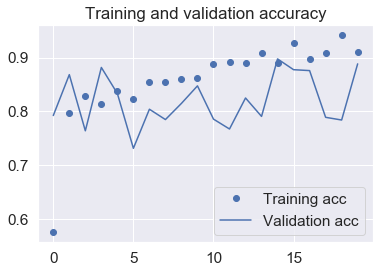

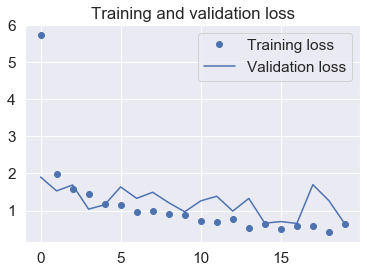

In [46]:
acc = history_V3.history['accuracy']
val_acc = history_V3.history['val_accuracy']
loss = history_V3.history['loss']
val_loss = history_V3.history['val_loss']

epochs = range(len(acc))

plot.plot(epochs, acc, 'bo', label='Training acc')
plot.plot(epochs, val_acc, 'b', label='Validation acc')
plot.title('Training and validation accuracy')
plot.legend()

plot.figure()

plot.plot(epochs, loss, 'bo', label='Training loss')
plot.plot(epochs, val_loss, 'b', label='Validation loss')
plot.title('Training and validation loss')
plot.legend()

plot.show()

### 3.4 Change the optimizer to SGD

In [47]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
model_InceptionV3_opt = models.Sequential()
model_InceptionV3_opt.add(layers.GlobalAveragePooling2D(input_shape=(3, 3, 2048)))
model_InceptionV3_opt.add(layers.Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model_InceptionV3_opt.add(layers.Dense(6, activation='softmax'))
model_InceptionV3_opt.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [48]:
history_V3_OPT = model_InceptionV3_opt.fit(train_featuresV3, y_train, batch_size=128, epochs=20, 
                    validation_data=(val_featuresV3, y_val))

Train on 3000 samples, validate on 1200 samples
Epoch 1/20
3000/3000 [==============================] - 0s 164us/step - loss: 2.4590 - accuracy: 0.6273 - val_loss: 2.0900 - val_accuracy: 0.7700
Epoch 2/20
3000/3000 [==============================] - 0s 120us/step - loss: 1.9492 - accuracy: 0.8340 - val_loss: 1.9327 - val_accuracy: 0.8192
Epoch 3/20
3000/3000 [==============================] - 0s 120us/step - loss: 1.8367 - accuracy: 0.8590 - val_loss: 1.8605 - val_accuracy: 0.8442
Epoch 4/20
3000/3000 [==============================] - 0s 120us/step - loss: 1.7756 - accuracy: 0.8747 - val_loss: 1.8536 - val_accuracy: 0.8500
Epoch 5/20
3000/3000 [==============================] - 0s 120us/step - loss: 1.7340 - accuracy: 0.8863 - val_loss: 1.8022 - val_accuracy: 0.8558
Epoch 6/20
3000/3000 [==============================] - 0s 120us/step - loss: 1.7031 - accuracy: 0.8970 - val_loss: 1.7868 - val_accuracy: 0.8650
Epoch 7/20
3000/3000 [==============================] - 0s 123us/step - loss

### 3.5 Accuracy and Loss (Optimal Model_inceptionV3)

In [49]:
val_loss_V3_opt = model_InceptionV3_opt.evaluate(val_featuresV3, y_val)
print(val_loss_V3_opt)

1200/1200 [==============================] - 0s 88us/step
[1.7025933202107748, 0.8833333253860474]


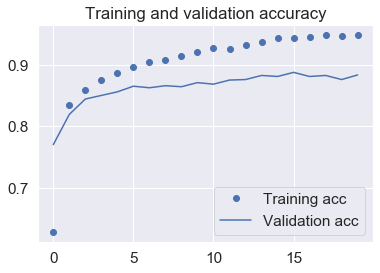

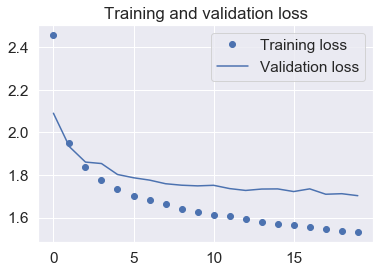

In [50]:
acc = history_V3_OPT.history['accuracy']
val_acc = history_V3_OPT.history['val_accuracy']
loss = history_V3_OPT.history['loss']
val_loss = history_V3_OPT.history['val_loss']

epochs = range(len(acc))

plot.plot(epochs, acc, 'bo', label='Training acc')
plot.plot(epochs, val_acc, 'b', label='Validation acc')
plot.title('Training and validation accuracy')
plot.legend()

plot.figure()

plot.plot(epochs, loss, 'bo', label='Training loss')
plot.plot(epochs, val_loss, 'b', label='Validation loss')
plot.title('Training and validation loss')
plot.legend()

plot.show()

## 4 Predict label of a test image using the optimal network 

The optimal model is model_InceptionV3_opt.


In [51]:
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras.preprocessing import image
from IPython.display import Image, display

### 4.1 Display Image

In [53]:
img_path="seg_pred/seg_pred/6.jpg"
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [54]:
preds_featuresInceptionV3 = InceptionV3_base.predict(x)

In [56]:
preds = model_InceptionV3_opt.predict(preds_featuresInceptionV3)

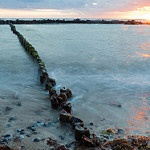

In [57]:
display(Image(img_path))

### 4.2 Print out 6 Probability Score

In [58]:
for i in range(preds.shape[1]):
    print('The probability of ',label_names[i],":",round(preds[0,i]*100, 5),"%")


The probability of  buildings : 0.0062 %
The probability of  forest : 0.07085 %
The probability of  glacier : 3.5049 %
The probability of  mountain : 0.14735 %
The probability of  sea : 95.65588 %
The probability of  street : 0.61482 %
